# Installing python modules used later on

In [1]:
#Uncomment if training on google colab!

!pip install pytorch_msssim

# Mount Google Drive

In [2]:
#Uncomment if training on google colab!

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


# Importing relevant things

In [3]:
import torch
import random
import numpy as np
from torch import nn, optim
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Subset, TensorDataset
import os
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
import torch.nn.functional as F
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from pytorch_msssim import SSIM
import random

# Config params

In [4]:
class Config:
    drive_path = "/content/drive/MyDrive"

    # uncomment if training in colab
    datasets_path = f"{drive_path}/splitted_cifar10_dataset.npz"
    weights_path = f"{drive_path}/weights"

    #for local
    # datasets_path = f"../../Dataset/splitted_cifar10_dataset.npz"
    # weights_path = f"../weights"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    sigma = 0.1
    num_nodes = 11

    learning_rate = 0.0015
    weight_decay = 1e-4
    grad_clip = 0.1

    batch_size = 1
    ucc_limit = 4
    rcc_limit = 10
    bag_size = 12

config = Config()

print(f"Training on {config.device}")

Training on cuda


# Loading the dataset

In [5]:
splitted_dataset = np.load(config.datasets_path)

x_train = splitted_dataset['x_train']
print(f"x_train shape :{x_train.shape}")

y_train = splitted_dataset['y_train']
print(f"y_train shape :{y_train.shape}")

x_val = splitted_dataset['x_val']
print(f"x_val shape :{x_val.shape}")

y_val = splitted_dataset['y_val']
print(f"y_val shape :{y_val.shape}")

x_test = splitted_dataset['x_test']
print(f"x_test shape :{x_test.shape}")

y_test = splitted_dataset['y_test']
print(f"y_test shape: {y_test.shape}")


x_train shape :(40000, 32, 32, 3)
y_train shape :(40000, 1)
x_val shape :(10000, 32, 32, 3)
y_val shape :(10000, 1)
x_test shape :(10000, 32, 32, 3)
y_test shape: (10000, 1)


# Custom Dataloader

This dataloader moves data directly to the device when yielding data

In [6]:
'''
Wrapper on top of dataloader to move tensors to device
'''
class DeviceDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, shuffle=True):
        super().__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle
        )
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def __iter__(self):
        for batch in super().__iter__():
            yield self._move_to_device(batch)

    def _move_to_device(self, batch):
        if isinstance(batch, torch.Tensor):
            return batch.to(self.device)
        elif isinstance(batch, (list, tuple)):
            return [self._move_to_device(item) for item in batch]
        elif isinstance(batch, dict):
            return {key: self._move_to_device(value) for key, value in batch.items()}
        else:
            return batch


# Defining Dataset

In [7]:
class Dataset:
    def __init__(self, x_train, y_train, x_val, y_val, x_test, y_test,
                 debug=False, apply_augmentation=True,
                 batch_size=config.batch_size, bag_size=config.bag_size,
                 ucc_limit=config.ucc_limit, rcc_limit=config.rcc_limit
                 ):
        '''
        Note these are numpy arrays

        :param x_train:
        :param y_train:
        :param x_val:
        :param y_val:
        :param x_test:
        :param y_test:
        '''
        self.num_classes = rcc_limit
        self.bag_size = bag_size
        self.ucc_limit = ucc_limit
        self.rcc_limit = rcc_limit
        self.batch_size = batch_size
        self.debug = debug
        self.debug_bag_size = 12
        self.apply_augmentation = apply_augmentation

        # transforms to apply
        self.transforms = [
            # normal
            transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor()
            ]),
            # random horizontal flips
            transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor()
            ]),
            # random rotations
            transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomRotation(3),
                transforms.ToTensor()
            ]),
            # random rotations & flips
            transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomRotation(3),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor()
            ])
        ]

        # converting it all into a tensor (it's not yet one hotified)
        self.x_train = torch.from_numpy(x_train).to(dtype=torch.float32)
        # normalizing the dataset, remove if it doesnt work
        # self.x_train, self.train_mu, self.train_std = self.normalize(self.x_train)
        self.y_train = torch.from_numpy(y_train).to(dtype=torch.int64)

        self.x_test = torch.from_numpy(x_test).to(dtype=torch.float32)
        # normalizing the dataset, remove if it doesnt work
        # self.x_test, self.test_mu, self.test_std = self.normalize(self.x_test)
        self.y_test = torch.from_numpy(y_test).to(dtype=torch.int64)

        # restricting x_val a lot more
        # Generate random indices for sampling without replacement
        random_indices = torch.randperm(len(x_test))
        x_val = x_val[random_indices[:len(x_test)//10]]
        y_val = y_val[random_indices[:len(x_test)//10]]

        self.x_val = torch.from_numpy(x_val).to(dtype=torch.float32)
        # normalizing the dataset, remove if it doesnt work
        # self.x_val, self.val_mu, self.val_std = self.normalize(self.x_val)
        self.y_val = torch.from_numpy(y_val).to(dtype=torch.int64)

        # Dividing all images by 255 to get an image in range 0->1
        self.x_train /= 255
        self.x_test /= 255
        self.x_val /= 255

        print("Converted numpy to torch tensors")

        # create subdatasets ([class_0_imgs, class_1_imgs,... class_9_imgs])
        self.train_sub_datasets = self.create_sub_datasets(self.x_train, self.y_train)
        self.test_sub_datasets = self.create_sub_datasets(self.x_test, self.y_test)
        self.val_sub_datasets = self.create_sub_datasets(self.x_val, self.y_val)

        # create dataloaders
        print("Creating KDE dataloaders")
        self.kde_test_dataloaders = self.create_kde_dataloaders(self.test_sub_datasets)

        print("Created KDE dataloaders, now creating autoencoder dataloaders")
        # batch size is 1 as we care about image level features anyway
        self.autoencoder_test_dataloaders = [DeviceDataLoader(test_sub_dataset, 1) for test_sub_dataset in
                                             self.test_sub_datasets]
        print("Created autoencoder dataloaders, now creating ucc dataloaders")
        self.ucc_train_dataloader, self.ucc_test_dataloader, self.ucc_val_dataloader = self.get_dataloaders_for_ucc()
        print("Created ucc dataloaders, now creating rcc dataloaders")
        self.ucc_rcc_train_dataloader, self.ucc_rcc_test_dataloader, self.ucc_rcc_val_dataloader = self.get_dataloaders_for_ucc_and_rcc()

        print("Initilized all dataloaders")

    # create dataloaders
    def create_kde_dataloaders(self, sub_datasets):
        kde_datasets = []

        for chosen_class, pure_sub_dataset in tqdm(enumerate(sub_datasets)):
            total_bags_for_pure_subset = len(pure_sub_dataset) // self.bag_size
            bag_tensors = []

            pure_sub_dataset_idx = 0
            current_bag = self.create_bag()

            while pure_sub_dataset_idx < len(pure_sub_dataset):
                # get the image from this pure sub dataset
                img = pure_sub_dataset[pure_sub_dataset_idx][0]
                bag_idx = pure_sub_dataset_idx % self.bag_size
                current_bag[bag_idx] = img

                if bag_idx == self.bag_size - 1:
                    # the last value has been filled, so add it to the total bags
                    bag_tensors.append(torch.stack(current_bag))

                    # create a new bag for the next set of bags to be filled
                    current_bag = self.create_bag()
                pure_sub_dataset_idx += 1

            kde_datasets.append(TensorDataset(torch.stack(bag_tensors)))

        print("Finished constructing the kde_datasets from the test dataset, now creating dataloaders")

        # NOTE. the batch size here can be different if required.
        kde_data_loaders = [DeviceDataLoader(kde_sub_dataset, self.batch_size) for kde_sub_dataset in kde_datasets]
        return kde_data_loaders

    def get_dataloaders_for_ucc(self):
        train_dataset_with_ucc, test_dataset_with_ucc, val_dataset_with_ucc = self.construct_datasets_with_ucc()
        return DeviceDataLoader(train_dataset_with_ucc, self.batch_size), \
            DeviceDataLoader(test_dataset_with_ucc, self.batch_size), \
            DeviceDataLoader(val_dataset_with_ucc, self.batch_size)

    def get_dataloaders_for_ucc_and_rcc(self):
        train_dataset_with_ucc_and_rcc, test_dataset_with_ucc_and_rcc, val_dataset_with_ucc_and_rcc = self.construct_datasets_with_ucc_and_rcc()
        return DeviceDataLoader(train_dataset_with_ucc_and_rcc, self.batch_size), \
            DeviceDataLoader(test_dataset_with_ucc_and_rcc, self.batch_size), \
            DeviceDataLoader(val_dataset_with_ucc_and_rcc, self.batch_size)

    # create sub datasets
    def create_sub_datasets(self, x, y):
        # Initialize an empty list to store the sub-datasets
        sub_datasets = []

        # Split the original dataset into 10 sub-datasets
        for class_label in range(self.num_classes):
            # Select indices for the current class
            indices = torch.where(y == class_label)[0]

            # Extract data for the current class
            x_class = [torch.tensor(item).permute(2, 0, 1) for item in x[indices]]
            y_class = [torch.tensor(item) for item in y[indices]]

            if len(x_class) > 0 and len(y_class) > 0:
                # Create a TensorDataset for the current class
                class_dataset = TensorDataset(torch.stack(x_class), torch.stack(y_class))

                # Append the current class dataset to the list
                sub_datasets.append(class_dataset)
        return sub_datasets

    # pick random image from ith class
    def pick_random_from_ith_sub_dataset(self, sub_datasets, i, is_eval):
        assert 0 <= i < self.num_classes
        sub_dataset = sub_datasets[i]
        sub_dataset_length = len(sub_dataset)
        random_idx = random.randint(0, sub_dataset_length - 1)
        random_img = sub_dataset[random_idx][0]
        if self.apply_augmentation and not is_eval:
            random_transform = random.choice(self.transforms)
            random_img = random_transform(random_img)
        return random_img.to(torch.float32)

    # construct UCC dataset
    def construct_datasets_with_ucc(self):
        train_dataset_with_ucc = self.construct_dataset_with_ucc(self.train_sub_datasets, False)
        test_dataset_with_ucc = self.construct_dataset_with_ucc(self.test_sub_datasets, True)
        val_dataset_with_ucc = self.construct_dataset_with_ucc(self.val_sub_datasets, True)

        return train_dataset_with_ucc, test_dataset_with_ucc, val_dataset_with_ucc

    def construct_dataset_with_ucc(self, sub_datasets, is_eval):
        bag_tensors = []
        ucc_tensors = []

        # calculate no of bags needed (NOTE: we are not going to pick every image here!)
        total_bags = 0
        for sub_dataset in sub_datasets:
            total_bags += len(sub_dataset)
        total_bags = total_bags // self.bag_size
        loop = self.debug_bag_size if self.debug else total_bags

        # NOTE: we can technically pick more images before I am not enforcing that I am picking every image.
        for b in tqdm(range(loop)):
            # this will keep picking ucc (1 -> 4) in a cyclic manner
            ucc = (b % self.ucc_limit) + 1
            bag_tensor = self.create_bag()

            # you are choosing random classes of size {ucc}. Using this knowledge you have to fill the bag up.
            img_per_class = self.bag_size // ucc
            chosen_classes = random.sample(list(range(self.num_classes)), ucc)
            class_at_each_pos_in_bag = []
            for chosen_class in chosen_classes:
                class_at_each_pos_in_bag.extend([chosen_class] * img_per_class)

            for bag_pos, chosen_class in enumerate(class_at_each_pos_in_bag):
                bag_tensor[bag_pos] = self.pick_random_from_ith_sub_dataset(sub_datasets, chosen_class, is_eval)

            '''
            #Uncomment this section if you want to try random filling
            random_bag_pos = random.sample(list(range(self.bag_size)), self.bag_size)

            # fill all the values for ucc first and then fill the remaining with random sampling with replacement
            for chosen_class, bag_pos in zip(chosen_classes, random_bag_pos[:len(chosen_classes)]):
                bag_tensor[bag_pos] = self.pick_random_from_ith_sub_dataset(sub_datasets, chosen_class, is_eval)

            # fill bag_tensor pos by pos
            for bag_pos in random_bag_pos[len(chosen_classes):]:
                chosen_class = random.choice(chosen_classes)
                bag_tensor[bag_pos] = self.pick_random_from_ith_sub_dataset(sub_datasets, chosen_class, is_eval)

            '''
            bag_tensors.append(torch.stack(bag_tensor))
            ucc_tensors.append(self.one_hot(ucc, self.ucc_limit))

        return TensorDataset(
            torch.stack(bag_tensors),
            torch.stack(ucc_tensors)
        )

    # create UCC and RCC dataset
    def construct_datasets_with_ucc_and_rcc(self):
        train_dataset_with_ucc_and_rcc = self.construct_dataset_with_ucc_and_rcc(self.train_sub_datasets, False)
        test_dataset_with_ucc_and_rcc = self.construct_dataset_with_ucc_and_rcc(self.val_sub_datasets, True)
        val_dataset_with_ucc_and_rcc = self.construct_dataset_with_ucc_and_rcc(self.test_sub_datasets, True)

        return train_dataset_with_ucc_and_rcc, test_dataset_with_ucc_and_rcc, val_dataset_with_ucc_and_rcc

    def construct_dataset_with_ucc_and_rcc(self, sub_datasets, is_eval):
        bag_tensors = []
        ucc_tensors = []
        rcc_tensors = []

        # calculate no of bags needed (NOTE: we are not going to pick every image here!)
        total_bags = 0
        for sub_dataset in sub_datasets:
            total_bags += len(sub_dataset)
        total_bags = total_bags // self.bag_size
        loop = self.debug_bag_size if self.debug else total_bags

        for b in tqdm(range(loop)):  # use this for local testing!
            # for b in tqdm(range(total_bags)):
            # this will keep picking ucc (1 -> 4) in a cyclic manner
            ucc = (b % self.ucc_limit) + 1
            bag_tensor = self.create_bag()
            rcc_tensor = [0] * self.rcc_limit

            # you are choosing random classes of size {ucc}. Using this knowledge you have to fill the bag up.
            img_per_class = self.bag_size // ucc
            chosen_classes = random.sample(list(range(self.num_classes)), ucc)
            class_at_each_pos_in_bag = []
            for chosen_class in chosen_classes:
                class_at_each_pos_in_bag.extend([chosen_class] * img_per_class)

            for bag_pos, chosen_class in enumerate(class_at_each_pos_in_bag):
                bag_tensor[bag_pos] = self.pick_random_from_ith_sub_dataset(sub_datasets, chosen_class, is_eval)
                rcc_tensor[chosen_class] += 1

            '''
            #Uncomment this section if you want to try random filling
            random_bag_pos = random.sample(list(range(self.bag_size)), self.bag_size)

            # fill all the values for ucc first and then fill the remaining with random sampling with replacement
            for chosen_class, bag_pos in zip(chosen_classes, random_bag_pos[:len(chosen_classes)]):
                bag_tensor[bag_pos] = self.pick_random_from_ith_sub_dataset(sub_datasets, chosen_class, is_eval)
                rcc_tensor[chosen_class] += 1

            # fill bag_tensor pos by pos
            for bag_pos in random_bag_pos[len(chosen_classes):]:
                chosen_class = random.choice(chosen_classes)
                bag_tensor[bag_pos] = self.pick_random_from_ith_sub_dataset(sub_datasets, chosen_class, is_eval)
                rcc_tensor[chosen_class] += 1
            '''

            bag_tensors.append(torch.stack(bag_tensor))
            ucc_tensors.append(self.one_hot(ucc, self.ucc_limit))
            rcc_tensors.append(torch.tensor(rcc_tensor))

        return TensorDataset(
            torch.stack(bag_tensors),
            torch.stack(ucc_tensors),
            torch.stack(rcc_tensors),
        )

    # util
    def one_hot(self, label, limit):
        # Create a one-hot tensor
        one_hot = torch.zeros(limit)

        # since each label is in range of [1,10] getting it to a range of [0,9]
        one_hot[label - 1] = 1
        return one_hot

    def create_bag(self):
        return [None] * self.bag_size


## Creating the dataset object

In [8]:
dataset = Dataset(x_train, y_train, x_val, y_val, x_test, y_test, debug=False, apply_augmentation=True)

Converted numpy to torch tensors


<ipython-input-7-a2463a23523e>:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_class = [torch.tensor(item).permute(2, 0, 1) for item in x[indices]]
<ipython-input-7-a2463a23523e>:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_class = [torch.tensor(item) for item in y[indices]]


Creating KDE dataloaders


0it [00:00, ?it/s]

Finished constructing the kde_datasets from the test dataset, now creating dataloaders
Created KDE dataloaders, now creating autoencoder dataloaders
Created autoencoder dataloaders, now creating ucc dataloaders


  0%|          | 0/3333 [00:00<?, ?it/s]

  0%|          | 0/833 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Created ucc dataloaders, now creating rcc dataloaders


  0%|          | 0/3333 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/833 [00:00<?, ?it/s]

Initilized all dataloaders


# Checking how one bag looks like

Checking out train


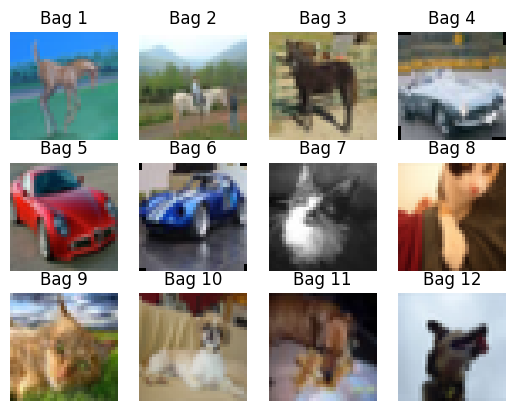

Checking out test


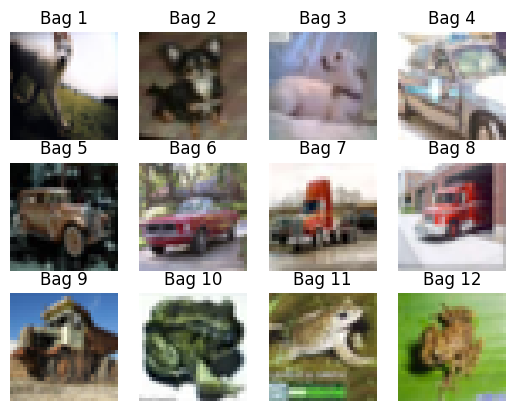

Checking out val


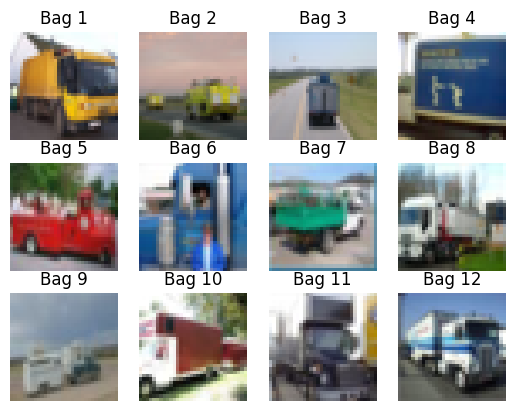

In [9]:
#printing the images in a bag
import matplotlib.pyplot as plt

tensor_to_img_transform = transforms.ToPILImage()
dataloaders = [dataset.ucc_train_dataloader, dataset.ucc_test_dataloader, dataset.ucc_val_dataloader]
names = ["train", "test", "val"]

for ucc_dataloader, name in zip(dataloaders, names):
    print(f"Checking out {name}")
    for data in ucc_dataloader:
        batches, _ = data
        for bag in batches:
            for image_index, image in enumerate(bag):
                # image *= 255
                image = tensor_to_img_transform(image)
                plt.subplot(3, 4, image_index + 1)  # Assuming 12 images per bag
                plt.imshow(image)  # Display the image
                plt.title(f"Bag {image_index + 1}")  # Set the title
                plt.axis('off')  # Turn off axis labels
            plt.show()
            break
        break
plt.show()



## Define the class names

In [10]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


## SSIM Loss definition

In [11]:
class SSIMLoss(nn.Module):
    def __init__(self):
        super(SSIMLoss, self).__init__()
        self.ssim = SSIM()

    def forward(self, x, y):
        # Calculate SSIM
        ssim_value = self.ssim(x, y)
        # Subtract SSIM from 1
        loss = 1 - ssim_value
        return loss

# Model architectures

## Autoencoder

In [12]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1, dtype=torch.float32),  # [batch, 12, 16, 16]
            # nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1, dtype=torch.float32),  # [batch, 24, 8, 8]
            # nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1, dtype=torch.float32),  # [batch, 48, 4, 4]
            # nn.BatchNorm2d(48),
            nn.Flatten(),
            nn.Linear(48 * 16, 48 * 16, dtype=torch.float32),
            nn.Sigmoid()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1, dtype=torch.float32),  # [batch, 24, 8, 8]
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1, dtype=torch.float32),  # [batch, 12, 16, 16]
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1, dtype=torch.float32),  # [batch, 3, 32, 32]
            nn.Sigmoid()
        )

        # Initialize weights using Xavier initialization with normal distribution
        # for m in self.modules():
        #     if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        #         nn.init.xavier_normal_(m.weight)
        #         nn.init.constant_(m.bias, 0.1)

        print("Autoencoder model initialized!")

    def forward(self, x):
        x = x.to(torch.float32)
        encoded = self.encoder(x)
        reshaped_encoded = encoded.view(-1, 48, 4, 4).to(torch.float32)
        decoded = self.decoder(reshaped_encoded).to(torch.float32)
        return encoded, decoded


## Kernel Density Estimator

In [13]:
class KDE(nn.Module):
    def __init__(self, device=config.device, num_nodes=config.num_nodes, sigma=config.sigma):
        super(KDE, self).__init__()
        self.num_nodes = num_nodes
        self.sigma = sigma
        self.device = device

    def forward(self, data):
        batch_size, bag_size, num_features = data.size()  # Batch, bag, J

        # Create a tensor for the sample points
        k_sample_points = torch.linspace(0, 1, steps=self.num_nodes).repeat(batch_size, bag_size, 1).to(
            self.device)  # B, bag, num_nodes

        # Constants
        k_alfa = 1 / np.sqrt(2 * np.pi * np.square(self.sigma))
        k_beta = -1 / (2 * self.sigma ** 2)

        out_list = []

        for j in range(num_features):
            data_j = data[:, :, j]  # shape (Batch, bag)
            temp_data = data_j.view(-1, bag_size, 1)  # shape (Batch, bag, 1)
            temp_data = temp_data.expand(-1, -1, self.num_nodes)  # shape ( Batch, bag, num_nodes)

            k_diff = k_sample_points - temp_data  # shape ( Batch, bag, num_nodes)
            k_diff_2 = torch.square(k_diff)  # shape ( Batch, bag, num_nodes)
            k_result = k_alfa * torch.exp(k_beta * k_diff_2)  # shape ( Batch, bag, num_nodes)
            k_out_unnormalized = torch.sum(k_result, dim=1)  # (B, num_nodes)
            k_norm_coeff = k_out_unnormalized.sum(dim=1).view(batch_size, 1)  # (B,1)
            k_out = k_out_unnormalized / k_norm_coeff.expand(-1, k_out_unnormalized.size(1))  # (B, num_nodes)

            out_list.append(k_out)
        # out_list is of shape (J, B, num_nodes)
        concat_out = torch.cat(out_list, dim=-1)  # shape is (Batch, J*num_nodes)
        return concat_out  # shape is (Batch, J*num_nodes) -> (1, 8448)

## UCC Prediction model

In [14]:
class UCCPredictor(nn.Module):
    def __init__(self, device=config.device, ucc_limit=config.ucc_limit):
        super().__init__()
        # Input size: [Batch, Bag, 48*16]
        # Output size: [Batch, 4]
        self.kde = KDE(device)
        self.stack = nn.Sequential(
            nn.MaxPool1d(kernel_size=2, stride=2),  # shape 4224
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=2, stride=2),  # shape 2112
            nn.ReLU(),
            nn.Linear(2112, 256, dtype=torch.float32),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(256, 32, dtype=torch.float32),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(32, ucc_limit, dtype=torch.float32),
            nn.Sigmoid()
        )

        # Initialize weights using Xavier initialization with normal distribution
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        kde_prob_distributions = self.kde(x)  # shape (Batch, 8448)
        ucc_logits = self.stack(kde_prob_distributions)  # shape (Batch, 4)
        return ucc_logits


## RCC Prediction model

This is the additional multi task path which predicts the "Real Class Counts"

In [15]:
class RCCPredictor(nn.Module):
    def __init__(self, device=config.device, rcc_limit=config.rcc_limit):
        super().__init__()
        # Input size: [Batch, Bag, 48*16]
        # Output size: [Batch, 4]
        self.kde = KDE(device)
        self.stack = nn.Sequential(
            nn.MaxPool1d(kernel_size=2, stride=2),  # shape 4224
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=2, stride=2),  # shape 2112
            nn.ReLU(),
            nn.Linear(2112, 256),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(256, 32),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(32, rcc_limit),
            nn.ReLU()
        )

        # Initialize weights using Xavier initialization with normal distribution
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                nn.init.xavier_normal_(m.weight)

    def forward(self, x):
        kde_prob_distributions = self.kde(x)  # shape (Batch, 8448)
        rcc_logits = self.stack(kde_prob_distributions)  # shape (Batch, 10)
        return rcc_logits

# EXPERIMENT-1 : UCC Model

This model tries to replicate the paper where we have an autoencoder path and a ucc path.

Similarly experiment-2 will be the improvement model

## Code for plotting the model stats

In [16]:
def plot_ucc_model_stats(
        experiment, epochs,
        ucc_training_losses, ae_training_losses, combined_training_losses,
        ucc_training_accuracy,
        ucc_validation_losses, ae_validation_losses, combined_validation_losses,
        ucc_validation_accuracy
    ):
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    # Plot training losses
    axes[0, 0].plot(epochs, ucc_training_losses, marker="o", color="red", label="UCC Training Loss")
    axes[0, 0].plot(epochs, ae_training_losses, marker="o", color="blue", label="AE Training Loss")
    axes[0, 0].plot(epochs, combined_training_losses, marker="o", color="green", label="Combined Training Loss")
    axes[0, 0].set_title(f'{experiment}: Training Loss vs Epochs')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Training Loss')
    axes[0, 0].legend()  # Display the legend

    # Plot training accuracy
    axes[0, 1].plot(epochs, ucc_training_accuracy, marker="o", color="red", label="UCC Training Accuracy")
    axes[0, 1].set_title(f'{experiment}: Training Accuracy vs Epochs')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Training Accuracy')
    axes[0, 1].legend()  # Display the legend

    # Plot validation losses
    axes[1, 0].plot(epochs, ucc_validation_losses, marker="o", color="red", label="UCC Validation Loss")
    axes[1, 0].plot(epochs, ae_validation_losses, marker="o", color="blue", label="AE Validation Loss")
    axes[1, 0].plot(epochs, combined_validation_losses, marker="o", color="green", label="Combined Validation Loss")
    axes[1, 0].set_title(f'{experiment}: Validation Loss vs Epochs')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Validation Loss')
    axes[1, 0].legend()  # Display the legend

    # Plot validation accuracy 1,1
    axes[1, 1].plot(epochs, ucc_validation_accuracy, marker="o", color="red", label="UCC Validation Accuracy")
    axes[1, 1].set_title(f'{experiment}: Validation Accuracy vs Epochs')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Validation Accuracy')
    axes[1, 1].legend()  # Display the legend

    # Add space between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

    # close it properly
    plt.clf()
    plt.cla()
    plt.close()

## UCC Trainer class

In [17]:
class UCCTrainer:
    def __init__(self,
                 name, autoencoder_model, ucc_predictor_model,
                 dataset, save_dir, device=config.device):
        self.name = name
        self.save_dir = save_dir
        self.device = device

        # data
        self.dataset = dataset
        self.train_loader = dataset.ucc_train_dataloader
        self.test_loader = dataset.ucc_test_dataloader
        self.val_loader = dataset.ucc_val_dataloader
        self.kde_loaders = dataset.kde_test_dataloaders  # each dataloader here will return shape of (batch, bag, 3,32,32) of a pure dataset
        self.autoencoder_loaders = dataset.autoencoder_test_dataloaders

        # create the directory if it doesn't exist!
        os.makedirs(self.save_dir, exist_ok=True)
        os.makedirs(os.path.join(self.save_dir, self.name), exist_ok=True)

        self.autoencoder_model = autoencoder_model
        self.ucc_predictor_model = ucc_predictor_model

        # Adam optimizer(s)
        self.ae_optimizer = optim.Adam(self.autoencoder_model.parameters(), lr=config.learning_rate,
                                       weight_decay=config.weight_decay)
        self.ucc_optimizer = optim.Adam(self.ucc_predictor_model.parameters(), lr=config.learning_rate,
                                        weight_decay=config.weight_decay)

        # Loss criterion(s)
        # self.ae_loss_criterion = nn.MSELoss()
        self.ae_loss_criterion = SSIMLoss()
        self.ucc_loss_criterion = nn.CrossEntropyLoss()

        # Transforms
        self.tensor_to_img_transform = transforms.ToPILImage()

        # Values which can change based on loaded checkpoint
        self.start_epoch = 0
        self.epoch_numbers = []
        self.training_ae_losses = []
        self.training_ucc_losses = []
        self.training_losses = []
        self.training_ucc_accuracies = []

        self.val_ae_losses = []
        self.val_ucc_losses = []
        self.val_losses = []
        self.val_ucc_accuracies = []

        self.train_correct_predictions = 0
        self.train_total_batches = 0

    # main train code
    def train(self,
              num_epochs,
              resume_epoch_num=None,
              load_from_checkpoint=False,
              epoch_saver_count=2):
        torch.cuda.empty_cache()

        # initialize the params from the saved checkpoint
        self.init_params_from_checkpoint_hook(load_from_checkpoint, resume_epoch_num)

        # set up scheduler
        self.init_scheduler_hook(num_epochs)

        # Custom progress bar for total epochs with color and displaying average epoch batch_loss
        total_progress_bar = tqdm(
            total=num_epochs, desc=f"Total Epochs", position=0,
            bar_format="{desc}: {percentage}% |{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]",
            dynamic_ncols=True, ncols=100, colour='red'
        )

        # Train loop
        for epoch in range(self.start_epoch, self.start_epoch + num_epochs):
            # Custom progress bar for each epoch with color
            epoch_progress_bar = tqdm(
                total=len(self.train_loader),
                desc=f"Epoch {epoch + 1}/{self.start_epoch + num_epochs}",
                position=1,
                leave=False,
                dynamic_ncols=True,
                ncols=100,
                colour='green'
            )

            # set all models to train mode
            self.autoencoder_model.train()
            self.ucc_predictor_model.train()

            # set the epoch training batch_loss
            epoch_training_loss = 0.0
            epoch_ae_loss = 0.0
            epoch_ucc_loss = 0.0

            # iterate over each batch
            for batch_idx, data in enumerate(self.train_loader):
                images, one_hot_ucc_labels = data

                # calculate losses from both models for a batch of bags
                ae_loss, encoded, decoded = self.forward_propagate_autoencoder(images)
                ucc_loss, batch_ucc_accuracy = self.forward_propogate_ucc(encoded, one_hot_ucc_labels, True)

                # calculate combined loss
                batch_loss = ae_loss + ucc_loss

                # do loss backward for all losses
                batch_loss.backward()

                # Gradient clipping (commenting this out as it is causing colab to crash!)
                # nn.utils.clip_grad_value_(self.autoencoder_model.parameters(), config.grad_clip)
                # nn.utils.clip_grad_value_(self.ucc_predictor_model.parameters(), config.grad_clip)

                # do optimizer step and zerograd for autoencoder model
                self.ae_optimizer.step()
                self.ae_optimizer.zero_grad()

                # do optimizer step and zerograd for ucc model
                self.ucc_optimizer.step()
                self.ucc_optimizer.zero_grad()

                # scheduler update (remove if it doesnt work!)
                self.ae_scheduler.step()
                self.ucc_scheduler.step()

                # add to epoch batch_loss
                epoch_training_loss += batch_loss.item()
                epoch_ae_loss += ae_loss.item()
                epoch_ucc_loss += ucc_loss.item()

                # Update the epoch progress bar (overwrite in place)
                batch_stats = {
                    "batch_loss": batch_loss.item(),
                    "ae_loss": ae_loss.item(),
                    "ucc_loss": ucc_loss.item(),
                    "batch_ucc_acc": batch_ucc_accuracy
                }

                epoch_progress_bar.set_postfix(batch_stats)
                epoch_progress_bar.update(1)

            # close the epoch progress bar
            epoch_progress_bar.close()

            # calculate average epoch train statistics
            avg_train_stats = self.calculate_avg_train_stats_hook(epoch_training_loss, epoch_ae_loss, epoch_ucc_loss)

            # calculate validation statistics
            avg_val_stats = self.validation_hook()

            # Store running history
            self.store_running_history_hook(epoch, avg_train_stats, avg_val_stats)

            # Show epoch stats
            print(f"# Epoch {epoch + 1}")
            epoch_postfix = self.calculate_and_print_epoch_stats_hook(avg_train_stats, avg_val_stats)

            # Update the total progress bar
            total_progress_bar.set_postfix(epoch_postfix)

            # Close tqdm bar
            total_progress_bar.update(1)

            # Save model checkpoint periodically
            need_to_save_model_checkpoint = (epoch + 1) % epoch_saver_count == 0
            if need_to_save_model_checkpoint:
                print(f"Going to save model {self.name} @ Epoch:{epoch + 1}")
                self.save_model_checkpoint_hook(epoch)

            print("-" * 60)

        # Close the total progress bar
        total_progress_bar.close()

        # Return the current state
        return self.get_current_running_history_state_hook()

    # hooks
    def init_params_from_checkpoint_hook(self, load_from_checkpoint, resume_epoch_num):
        if load_from_checkpoint:
            # NOTE: resume_epoch_num can be None here if we want to load from the most recently saved checkpoint!
            checkpoint_path = self.get_model_checkpoint_path(resume_epoch_num)
            checkpoint = torch.load(checkpoint_path)

            # load previous state of models
            self.autoencoder_model.load_state_dict(checkpoint['ae_model_state_dict'])
            self.ucc_predictor_model.load_state_dict(checkpoint['ucc_model_state_dict'])

            # load previous state of optimizers
            self.ae_optimizer.load_state_dict(checkpoint['ae_optimizer_state_dict'])
            self.ucc_optimizer.load_state_dict(checkpoint['ucc_optimizer_state_dict'])

            # Things we are keeping track of
            self.start_epoch = checkpoint['epoch']
            self.epoch_numbers = checkpoint['epoch_numbers']

            self.training_losses = checkpoint['training_losses']
            self.training_ae_losses = checkpoint['training_ae_losses']
            self.training_ucc_losses = checkpoint['training_ucc_losses']
            self.training_ucc_accuracies = checkpoint['training_ucc_accuracies']

            self.val_losses = checkpoint['val_losses']
            self.val_ae_losses = checkpoint['val_ae_losses']
            self.val_ucc_losses = checkpoint['val_ucc_losses']
            self.val_ucc_accuracies = checkpoint['val_ucc_accuracies']

            print(f"Model checkpoint for {self.name} is loaded from {checkpoint_path}!")

    def init_scheduler_hook(self, num_epochs):
        # steps per epoch here is multiplied with bag size as we are doing it at an image level
        self.ae_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.ae_optimizer,
            config.learning_rate,
            epochs=num_epochs,
            steps_per_epoch=len(self.train_loader)
            # steps_per_epoch=len(self.train_loader) * config.bag_size # this is only if I decide to go image by image level loss as opposed to bag level loss
        )

        # here we are doing it at a bag level
        self.ucc_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.ucc_optimizer,
            config.learning_rate,
            epochs=num_epochs,
            steps_per_epoch=len(self.train_loader)
        )

    def forward_propagate_autoencoder(self, images):
        # data is of shape (batchsize=2,bag=10,channels=3,height=32,width=32)
        # generally batch size of 16 is good for cifar10 so predicting 20 won't be so bad
        batch_size, bag_size, num_channels, height, width = images.size()
        batches_of_bag_images = images.view(batch_size * bag_size, num_channels, height, width).to(torch.float32)
        encoded, decoded = self.autoencoder_model(
            batches_of_bag_images)  # we are feeding in Batch*bag images of shape (3,32,32)
        ae_loss = self.ae_loss_criterion(decoded, batches_of_bag_images)  # compares (Batch * Bag, 3,32,32)
        return ae_loss, encoded, decoded

    def forward_propogate_ucc(self, encoded, one_hot_ucc_labels, is_train_mode=True):
        # encoded is of shape [Batch * Bag, 48*16] ->  make it into shape [Batch, Bag, 48*16]
        batch_times_bag_size, feature_size = encoded.size()
        bag_size = config.bag_size
        batch_size = batch_times_bag_size // bag_size
        encoded = encoded.view(batch_size, bag_size, feature_size)
        ucc_logits = self.ucc_predictor_model(encoded)

        # compute the ucc_loss between [batch, 4]
        ucc_loss = self.ucc_loss_criterion(ucc_logits, one_hot_ucc_labels)

        # compute the batch stats right here and save it
        ucc_probs = nn.Softmax(dim=1)(ucc_logits)
        predicted = torch.argmax(ucc_probs, 1)
        labels = torch.argmax(one_hot_ucc_labels, 1)
        batch_correct_predictions = (predicted == labels).sum().item()
        batch_size = labels.size(0)

        # calculate batchwise accuracy/ucc_loss
        batch_ucc_accuracy = batch_correct_predictions / batch_size
        if is_train_mode:
            self.train_correct_predictions += batch_correct_predictions
            self.train_total_batches += batch_size
        else:
            self.eval_correct_predictions += batch_correct_predictions
            self.eval_total_batches += batch_size
        return ucc_loss, batch_ucc_accuracy

    def calculate_avg_train_stats_hook(self, epoch_training_loss, epoch_ae_loss, epoch_ucc_loss):
        no_of_bags = len(self.train_loader) * config.batch_size
        avg_training_loss_for_epoch = epoch_training_loss / no_of_bags
        avg_ae_loss_for_epoch = epoch_ae_loss / no_of_bags
        avg_ucc_loss_for_epoch = epoch_ucc_loss / no_of_bags
        avg_ucc_training_accuracy = self.train_correct_predictions / self.train_total_batches

        epoch_train_stats = {
            "avg_training_loss": avg_training_loss_for_epoch,
            "avg_ae_loss": avg_ae_loss_for_epoch,
            "avg_ucc_loss": avg_ucc_loss_for_epoch,
            "avg_ucc_training_accuracy": avg_ucc_training_accuracy
        }

        # reset
        self.train_correct_predictions = 0
        self.train_total_batches = 0

        return epoch_train_stats

    def validation_hook(self):
        # class level init
        self.eval_correct_predictions = 0
        self.eval_total_batches = 0

        val_loss = 0.0
        val_ae_loss = 0.0
        val_ucc_loss = 0.0

        with torch.no_grad():
            # set all models to eval mode
            self.autoencoder_model.eval()
            self.ucc_predictor_model.eval()

            for val_batch_idx, val_data in enumerate(self.val_loader):
                val_images, val_one_hot_ucc_labels = val_data

                # calculate losses from both models for a batch of bags
                val_batch_ae_loss, val_encoded, val_decoded = self.forward_propagate_autoencoder(val_images)
                val_batch_ucc_loss, val_batch_ucc_accuracy = self.forward_propogate_ucc(val_encoded,
                                                                                        val_one_hot_ucc_labels,
                                                                                        False)

                # calculate combined loss
                val_batch_loss = val_batch_ae_loss + val_batch_ucc_loss

                # cummulate the losses
                val_ae_loss += val_batch_ae_loss.item()
                val_ucc_loss += val_batch_ucc_loss.item()
                val_loss += val_batch_loss.item()

        # Calculate average validation loss for the epoch
        no_of_bags = len(self.val_loader) * config.batch_size
        avg_val_loss = val_loss / no_of_bags
        avg_val_ucc_loss = val_ucc_loss / no_of_bags
        avg_val_ae_loss = val_ae_loss / no_of_bags
        avg_val_ucc_training_accuracy = self.eval_correct_predictions / self.eval_total_batches

        print("Finished computing val stats, now showing a sample reconstruction")
        # show some sample predictions
        self.show_sample_reconstructions(self.val_loader)

        return {
            "avg_val_loss": avg_val_loss,
            "avg_val_ae_loss": avg_val_ae_loss,
            "avg_val_ucc_loss": avg_val_ucc_loss,
            "avg_val_ucc_training_accuracy": avg_val_ucc_training_accuracy
        }

    def calculate_and_print_epoch_stats_hook(self, avg_train_stats, avg_val_stats):
        epoch_loss = avg_train_stats["avg_training_loss"]
        epoch_ae_loss = avg_train_stats["avg_ae_loss"]
        epoch_ucc_loss = avg_train_stats["avg_ucc_loss"]
        epoch_ucc_accuracy = avg_train_stats["avg_ucc_training_accuracy"]

        epoch_val_loss = avg_val_stats["avg_val_loss"]
        epoch_val_ae_loss = avg_val_stats["avg_val_ae_loss"]
        epoch_val_ucc_loss = avg_val_stats["avg_val_ucc_loss"]
        epoch_val_ucc_accuracy = avg_val_stats["avg_val_ucc_training_accuracy"]

        print(
            f"[TRAIN]: Epoch Loss: {epoch_loss} | AE Loss: {epoch_ae_loss} | UCC Loss: {epoch_ucc_loss} | UCC Acc: {epoch_ucc_accuracy}")
        print(
            f"[VAL]: Val Loss: {epoch_val_loss} | Val AE Loss: {epoch_val_ae_loss} | Val UCC Loss: {epoch_val_ucc_loss} | Val UCC Acc: {epoch_val_ucc_accuracy}")

        return {
            "epoch_loss": epoch_loss,
            "epoch_ae_loss": epoch_ae_loss,
            "epoch_ucc_loss": epoch_ucc_loss,
            "epoch_ucc_acc": epoch_ucc_accuracy,
            "epoch_val_loss": epoch_val_loss,
            "epoch_val_ae_loss": epoch_val_ae_loss,
            "epoch_val_ucc_loss": epoch_val_ucc_loss,
            "epoch_val_ucc_acc": epoch_val_ucc_accuracy
        }

    def store_running_history_hook(self, epoch, avg_train_stats, avg_val_stats):
        self.epoch_numbers.append(epoch + 1)

        self.training_ae_losses.append(avg_train_stats["avg_ae_loss"])
        self.training_ucc_losses.append(avg_train_stats["avg_ucc_loss"])
        self.training_losses.append(avg_train_stats["avg_training_loss"])
        self.training_ucc_accuracies.append(avg_train_stats["avg_ucc_training_accuracy"])

        self.val_ae_losses.append(avg_val_stats["avg_val_ae_loss"])
        self.val_ucc_losses.append(avg_val_stats["avg_val_ucc_loss"])
        self.val_losses.append(avg_val_stats["avg_val_loss"])
        self.val_ucc_accuracies.append(avg_val_stats["avg_val_ucc_training_accuracy"])

    def get_current_running_history_state_hook(self):
        return self.epoch_numbers, \
            self.training_ae_losses, self.training_ucc_losses, self.training_losses, self.training_ucc_accuracies, \
            self.val_ae_losses, self.val_ucc_losses, self.val_losses, self.val_ucc_accuracies

    def save_model_checkpoint_hook(self, epoch):
        # set it to train mode to save the weights (but doesn't matter apparently!)
        self.autoencoder_model.train()
        self.ucc_predictor_model.train()

        # create the directory if it doesn't exist
        model_save_directory = os.path.join(self.save_dir, self.name)
        os.makedirs(model_save_directory, exist_ok=True)

        # Checkpoint the model at the end of each epoch
        checkpoint_path = os.path.join(model_save_directory, f'model_epoch_{epoch + 1}.pt')
        torch.save(
            {
                'ae_model_state_dict': self.autoencoder_model.state_dict(),
                'ucc_model_state_dict': self.ucc_predictor_model.state_dict(),
                'ae_optimizer_state_dict': self.ae_optimizer.state_dict(),
                'ucc_optimizer_state_dict': self.ucc_optimizer.state_dict(),
                'epoch': epoch + 1,
                'epoch_numbers': self.epoch_numbers,
                'training_losses': self.training_losses,
                'training_ae_losses': self.training_ae_losses,
                'training_ucc_losses': self.training_ucc_losses,
                'training_ucc_accuracies': self.training_ucc_accuracies,
                'val_losses': self.val_losses,
                'val_ae_losses': self.val_ae_losses,
                'val_ucc_losses': self.val_ucc_losses,
                'val_ucc_accuracies': self.val_ucc_accuracies,
            },
            checkpoint_path
        )
        print(f"Saved the model checkpoint for experiment {self.name} for epoch {epoch + 1}")

    def test_model(self):
        # class level init
        self.eval_correct_predictions = 0
        self.eval_total_batches = 0

        test_loss = 0.0
        test_ae_loss = 0.0
        test_ucc_loss = 0.0

        with torch.no_grad():
            # set all models to eval mode
            self.autoencoder_model.eval()
            self.ucc_predictor_model.eval()

            for test_batch_idx, test_data in enumerate(self.test_loader):
                test_images, test_one_hot_ucc_labels = test_data

                # calculate losses from both models for a batch of bags
                test_batch_ae_loss, test_encoded, test_decoded = self.forward_propagate_autoencoder(test_images)
                test_batch_ucc_loss, test_batch_ucc_accuracy = self.forward_propogate_ucc(test_encoded,
                                                                                          test_one_hot_ucc_labels,
                                                                                          False)

                # calculate combined loss
                test_batch_loss = test_batch_ae_loss + test_batch_ucc_loss

                # cummulate the losses
                test_ae_loss += test_batch_ae_loss.item()
                test_ucc_loss += test_batch_ucc_loss.item()
                test_loss += test_batch_loss.item()

        # Calculate average validation loss for the epoch
        no_of_bags = len(self.test_loader) * config.batch_size
        avg_test_loss = test_loss / no_of_bags
        avg_test_ucc_loss = test_ucc_loss / no_of_bags
        avg_test_ae_loss = test_ae_loss / no_of_bags
        avg_test_ucc_training_accuracy = self.eval_correct_predictions / self.eval_total_batches

        # show some sample predictions
        self.show_sample_reconstructions(self.test_loader)

        return {
            "avg_test_loss": avg_test_loss,
            "avg_test_ae_loss": avg_test_ae_loss,
            "avg_test_ucc_loss": avg_test_ucc_loss,
            "avg_test_ucc_training_accuracy": avg_test_ucc_training_accuracy
        }

    def show_sample_reconstructions(self, dataloader):
        # Create a subplot grid
        fig, axes = plt.subplots(1, 2, figsize=(3, 3))

        with torch.no_grad():
            self.autoencoder_model.eval()

            for val_data in dataloader:
                val_images, _ = val_data

                # Forward pass through the model
                _, _, val_reconstructed_images = self.forward_propagate_autoencoder(val_images)

                print("Got a sample reconstruction, now trying to reshape in order to show an example")

                batch_size, bag_size, num_channels, height, width = val_images.size()
                bag_val_images = val_images.view(batch_size * bag_size, num_channels, height, width)

                print("Reshaped the original image into bag format")

                # take only one image from the bag
                sample_image = bag_val_images[0]
                predicted_image = val_reconstructed_images[0]

                # get it to cpu
                sample_image = sample_image.to("cpu")
                predicted_image = predicted_image.to("cpu")

                #get it back to the range of 0->255
                # sample_image *= 255
                # predicted_image *= 255

                # convert to PIL Image
                sample_image = self.tensor_to_img_transform(sample_image)
                predicted_image = self.tensor_to_img_transform(predicted_image)

                axes[0].imshow(sample_image)
                axes[0].set_title(f"Orig", color='green')
                axes[0].axis('off')

                axes[1].imshow(predicted_image)
                axes[1].set_title(f"Recon", color='red')
                axes[1].axis('off')

                # show only one image
                break

        plt.tight_layout()
        plt.show()

    def js_divergence(self, p, q):
        """
        Calculate the Jensen-Shannon Divergence between two probability distributions p and q.

        Args:
        p (torch.Tensor): Probability distribution p.
        q (torch.Tensor): Probability distribution q.

        Returns:
        torch.Tensor: Jensen-Shannon Divergence between p and q.
        """
        # Calculate the average distribution 'm'
        m = 0.5 * (p + q)

        # Calculate the KL Divergence of 'p' and 'q' from 'm'
        kl_div_p = F.kl_div(p.log(), m, reduction='batchmean')
        kl_div_q = F.kl_div(q.log(), m, reduction='batchmean')

        # Compute the JS Divergence
        js_divergence = 0.5 * (kl_div_p + kl_div_q)

        return js_divergence

    def calculate_min_js_divergence(self):
        num_classes = len(self.kde_loaders)
        kde_per_class = {class_idx: 0.0 for class_idx in range(num_classes)}

        # find the average kde across all classes
        for class_idx, pure_class_kde_loader in tqdm(enumerate(self.kde_loaders)):
            num_imgs_in_class = 0
            for images in pure_class_kde_loader:
                # get the first element
                images = images[0]
                # batch data is of shape ( Batch,bag, 3,32,32)
                batch_size, bag_size, num_channels, height, width = images.size()
                # reshaping to shape ( batch * bag, 3 ,32,32)
                batches_of_bag_images = images.view(batch_size * bag_size, num_channels, height, width).to(
                    torch.float32)
                latent_features = self.autoencoder_model.encoder(batches_of_bag_images)  # shape (Batch * bag, 48*16)
                latent_features = latent_features.to(torch.float32)

                # encoded is of shape [Batch * Bag, 48*16] ->  make it into shape [Batch, Bag, 48*16]
                batch_times_bag_size, feature_size = latent_features.size()
                bag_size = config.bag_size
                batch_size = batch_times_bag_size // bag_size
                latent_features = latent_features.view(batch_size, bag_size, feature_size)

                batch_kde_distributions = self.ucc_predictor_model.kde(latent_features)  # shape [Batch=2, 8448]
                num_imgs_in_class += batch_kde_distributions.size(0)
                kde_distributions = torch.sum(batch_kde_distributions, dim=0)
                kde_per_class[class_idx] += kde_distributions
            kde_per_class[class_idx] /= num_imgs_in_class

        # find the js_divergence
        min_divergence = torch.inf
        best_i = None
        best_j = None
        for i in range(num_classes):
            for j in range(i + 1, num_classes):
                divergence = self.js_divergence(kde_per_class[i], kde_per_class[j])
                print(f"JS Divergence between {i} & {j} is {divergence}")
                if divergence < min_divergence:
                    min_divergence = divergence
                    best_i = i
                    best_j = j

        print(f"Min JS Divergence is {min_divergence} between classes {best_i} & {best_j}")
        # return the min divergence
        return min_divergence

    def calculate_clustering_accuracy(self):
        all_latent_features = []
        truth_labels_arr = []
        for pure_autoencoder_loader in self.autoencoder_loaders:
            for batch_idx, data in tqdm(enumerate(pure_autoencoder_loader)):
                # batch data is of shape (1,3,32,32), (1,1)
                image, label = data
                latent_features = self.autoencoder_model.encoder(image)  # shape (1, 48*16)

                latent_features = latent_features.squeeze().detach().cpu().numpy()  # ndarray shape (48*16)
                label = label.squeeze().detach().cpu().numpy()  # ndarray shape (1)

                all_latent_features.append(latent_features)
                truth_labels_arr.append(label.item())

        all_latent_features = np.array(all_latent_features)
        truth_labels_arr = np.array(truth_labels_arr)
        print("Got the latent features for all test images, now doing Kmeans")

        # Do kmeans fit
        estimator = KMeans(n_clusters=10, init='k-means++', n_init=10)
        estimator.fit(all_latent_features)
        predicted_clustering_labels = estimator.labels_

        print("Got the kmeans predicted labels, now computing clustering accuracy")

        # Calculate accuracy
        cost_matrix = np.zeros((10, 10))
        num_samples = np.zeros(10)
        for truth_val in range(10):
            temp_sample_indices = np.where(truth_labels_arr == truth_val)[0]
            num_samples[truth_val] = temp_sample_indices.shape[0]

            temp_predicted_labels = predicted_clustering_labels[temp_sample_indices]

            for predicted_val in range(10):
                temp_matching_pairs = np.where(temp_predicted_labels == predicted_val)[0]
                cost_matrix[truth_val, predicted_val] = 1 - (
                        temp_matching_pairs.shape[0] / temp_sample_indices.shape[0])

        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        cost = cost_matrix[row_ind, col_ind]

        clustering_acc = ((1 - cost) * num_samples).sum() / num_samples.sum()
        return clustering_acc

    # find the most recent file and return the path
    def get_model_checkpoint_path(self, epoch_num=None):
        directory = os.path.join(self.save_dir, self.name)
        if epoch_num == None:
            # Get a list of all files in the directory
            files = os.listdir(directory)

            # Filter out only the files (exclude directories)
            files = [f for f in files if os.path.isfile(os.path.join(directory, f))]

            # Sort the files by their modification time in descending order (most recent first)
            files.sort(key=lambda x: os.path.getmtime(os.path.join(directory, x)), reverse=True)

            # Get the name of the most recently added file
            model_file = files[0] if files else None
        else:
            model_file = f"model_epoch_{epoch_num}.pt"
        return os.path.join(directory, model_file)


## Creating the model instances


In [18]:
experiment1 = "ucc"
save_dir = os.path.abspath(config.weights_path)
autoencoder_ucc_model = Autoencoder().to(config.device)
ucc_predictor_model = UCCPredictor().to(config.device)

#creating the trainer
ucc_trainer = UCCTrainer(experiment1, autoencoder_ucc_model, ucc_predictor_model, dataset, save_dir)

Autoencoder model initialized!


## Training the model

Going to start training..


Total Epochs: 0.0% |          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/3333 [00:00<?, ?it/s]

Finished computing val stats, now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example
Reshaped the original image into bag format


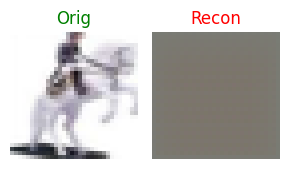

# Epoch 1
[TRAIN]: Epoch Loss: 1.3976382354770092 | AE Loss: 0.006133256661723836 | UCC Loss: 1.3915049769375512 | UCC Acc: 0.24962496249624963
[VAL]: Val Loss: 1.3956477340445461 | Val AE Loss: 0.0062269963413836005 | Val UCC Loss: 1.3894207448844451 | Val UCC Acc: 0.24096385542168675
Going to save model ucc @ Epoch:1
Saved the model checkpoint for experiment ucc for epoch 1
------------------------------------------------------------


Epoch 2/20:   0%|          | 0/3333 [00:00<?, ?it/s]

Finished computing val stats, now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example
Reshaped the original image into bag format


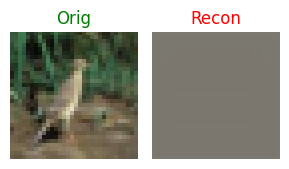

# Epoch 2
[TRAIN]: Epoch Loss: 1.395990849542718 | AE Loss: 0.006129968588394407 | UCC Loss: 1.389860879219655 | UCC Acc: 0.24962496249624963
[VAL]: Val Loss: 1.3930530849709568 | Val AE Loss: 0.006236551755882171 | Val UCC Loss: 1.3868165260337921 | Val UCC Acc: 0.25301204819277107
Going to save model ucc @ Epoch:2
Saved the model checkpoint for experiment ucc for epoch 2
------------------------------------------------------------


Epoch 3/20:   0%|          | 0/3333 [00:00<?, ?it/s]

Finished computing val stats, now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example
Reshaped the original image into bag format


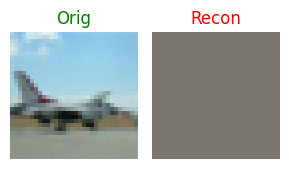

# Epoch 3
[TRAIN]: Epoch Loss: 1.3990614936761658 | AE Loss: 0.006133033461732404 | UCC Loss: 1.3929284582115171 | UCC Acc: 0.25232523252325234
[VAL]: Val Loss: 1.3924689379083104 | Val AE Loss: 0.00623814456434135 | Val UCC Loss: 1.386230793343969 | Val UCC Acc: 0.25301204819277107
Going to save model ucc @ Epoch:3
Saved the model checkpoint for experiment ucc for epoch 3
------------------------------------------------------------


Epoch 4/20:   0%|          | 0/3333 [00:00<?, ?it/s]

Finished computing val stats, now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example
Reshaped the original image into bag format


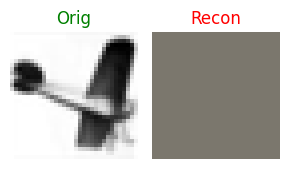

# Epoch 4
[TRAIN]: Epoch Loss: 1.3991752655843053 | AE Loss: 0.006132537650518363 | UCC Loss: 1.3930427254837912 | UCC Acc: 0.24842484248424843
[VAL]: Val Loss: 1.392548872763852 | Val AE Loss: 0.00623506953917354 | Val UCC Loss: 1.3863138003521656 | Val UCC Acc: 0.24096385542168675
Going to save model ucc @ Epoch:4
Saved the model checkpoint for experiment ucc for epoch 4
------------------------------------------------------------


Epoch 5/20:   0%|          | 0/3333 [00:00<?, ?it/s]

Finished computing val stats, now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example
Reshaped the original image into bag format


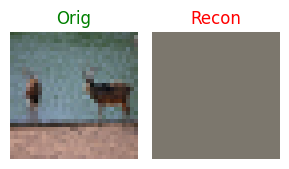

# Epoch 5
[TRAIN]: Epoch Loss: 1.4119317470782875 | AE Loss: 0.0061321471175952895 | UCC Loss: 1.405799598369089 | UCC Acc: 0.2532253225322532
[VAL]: Val Loss: 1.3926100501094956 | Val AE Loss: 0.006235277078237878 | Val UCC Loss: 1.3863747751856426 | Val UCC Acc: 0.24096385542168675
Going to save model ucc @ Epoch:5
Saved the model checkpoint for experiment ucc for epoch 5
------------------------------------------------------------


Epoch 6/20:   0%|          | 0/3333 [00:00<?, ?it/s]

Finished computing val stats, now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example
Reshaped the original image into bag format


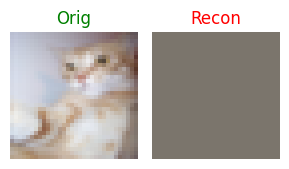

# Epoch 6
[TRAIN]: Epoch Loss: 1.3973147532190964 | AE Loss: 0.006132066482328775 | UCC Loss: 1.3911826862718049 | UCC Acc: 0.24032403240324032
[VAL]: Val Loss: 1.3925478199878372 | Val AE Loss: 0.006231516958719276 | Val UCC Loss: 1.3863163051835026 | Val UCC Acc: 0.25301204819277107
Going to save model ucc @ Epoch:6
Saved the model checkpoint for experiment ucc for epoch 6
------------------------------------------------------------


Epoch 7/20:   0%|          | 0/3333 [00:00<?, ?it/s]

Finished computing val stats, now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example
Reshaped the original image into bag format


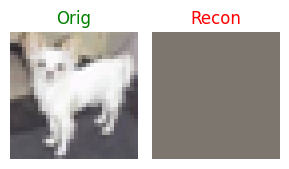

# Epoch 7
[TRAIN]: Epoch Loss: 1.393175324340715 | AE Loss: 0.006132549453418319 | UCC Loss: 1.3870427739394882 | UCC Acc: 0.23372337233723373
[VAL]: Val Loss: 1.3925303852701763 | Val AE Loss: 0.00623647850680064 | Val UCC Loss: 1.3862939010183495 | Val UCC Acc: 0.25301204819277107
Going to save model ucc @ Epoch:7
Saved the model checkpoint for experiment ucc for epoch 7
------------------------------------------------------------


Epoch 8/20:   0%|          | 0/3333 [00:00<?, ?it/s]

Finished computing val stats, now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example
Reshaped the original image into bag format


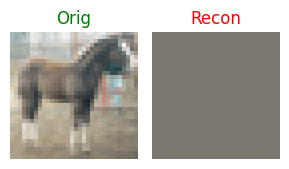

# Epoch 8
[TRAIN]: Epoch Loss: 1.3943038510732597 | AE Loss: 0.006132383604790762 | UCC Loss: 1.3881714664491276 | UCC Acc: 0.2556255625562556
[VAL]: Val Loss: 1.3925272930099304 | Val AE Loss: 0.006239962865071124 | Val UCC Loss: 1.3862873301448593 | Val UCC Acc: 0.25301204819277107
Going to save model ucc @ Epoch:8
Saved the model checkpoint for experiment ucc for epoch 8
------------------------------------------------------------


Epoch 9/20:   0%|          | 0/3333 [00:00<?, ?it/s]

In [ ]:
print("Going to start training..")
exp1_epoch_numbers, exp1_training_ae_losses, exp1_training_ucc_losses, exp1_training_losses, exp1_training_ucc_accuracies, exp1_val_ae_losses, exp1_val_ucc_losses, exp1_val_losses, exp1_val_ucc_accuracies = ucc_trainer.train(20, epoch_saver_count=1)

## Additional Training if required

In [ ]:
# exp1_epoch_numbers, exp1_training_ae_losses, exp1_training_ucc_losses, exp1_training_losses, exp1_training_ucc_accuracies, exp1_val_ae_losses, exp1_val_ucc_losses, exp1_val_losses, exp1_val_ucc_accuracies = ucc_trainer.train(10, epoch_saver_count=2, load_from_checkpoint=True, resume_epoch_num=42)

## Plotting the model stats

In [ ]:
plot_ucc_model_stats(experiment1, exp1_epoch_numbers, exp1_training_ucc_losses, exp1_training_ae_losses, exp1_training_losses,
                     exp1_training_ucc_accuracies, exp1_val_ucc_losses, exp1_val_ae_losses, exp1_val_losses,
                     exp1_val_ucc_accuracies)

## Testing the model

In [ ]:
ucc_trainer.test_model()

## Calculating the Min JS Divergence

In [ ]:
exp1_min_js_divg = ucc_trainer.calculate_min_js_divergence()
exp1_min_js_divg

## Calculating the Clustering Accuracy

In [ ]:
exp1_clustering_accuracies = ucc_trainer.calculate_clustering_accuracy()
exp1_clustering_accuracies

In [ ]:
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#

# EXPERIMENT-2 : UCC-RCC Model

This model is an improvement to the original model as we are also trying to predict the RCC (Real Class Counts) as a separate multitask path. This approach in theory should improve the accuracy of the model.

Additionally we use the SSIM loss for the autoencoder as that is known to be a good loss function when it comes to autoencoders.



## Code for plotting the model stats

In [ ]:
def plot_ucc_rcc_model_stats(
        experiment, epochs,
        ucc_training_losses, ae_training_losses, rcc_training_losses, combined_training_losses,
        ucc_training_accuracy, rcc_training_accuracy,
        ucc_validation_losses, ae_validation_losses, rcc_validation_losses, combined_validation_losses,
        ucc_validation_accuracy, rcc_validation_accuracy
    ):
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))

    # Plot training losses
    axes[0, 0].plot(epochs, ucc_training_losses, marker="o", color="red", label="UCC Training Loss")
    axes[0, 0].plot(epochs, ae_training_losses, marker="o", color="blue", label="AE Training Loss")
    axes[0, 0].plot(epochs, rcc_training_losses, marker="o", color="yellow", label="RCC Training Loss")
    axes[0, 0].plot(epochs, combined_training_losses, marker="o", color="green", label="Combined Training Loss")
    axes[0, 0].set_title(f'{experiment}: Training Loss vs Epochs')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Training Loss')
    axes[0, 0].legend()  # Display the legend

    # Plot training accuracy
    axes[0, 1].plot(epochs, ucc_training_accuracy, marker="o", color="red", label="UCC Training Accuracy")
    axes[0, 1].plot(epochs, rcc_training_accuracy, marker="o", color="green", label="RCC Training Accuracy")
    axes[0, 1].set_title(f'{experiment}: Training Accuracy vs Epochs')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Training Accuracy')
    axes[0, 1].legend()  # Display the legend

    # Plot validation losses
    axes[1, 0].plot(epochs, ucc_validation_losses, marker="o", color="red", label="UCC Validation Loss")
    axes[1, 0].plot(epochs, ae_validation_losses, marker="o", color="blue", label="AE Validation Loss")
    axes[1, 0].plot(epochs, rcc_validation_losses, marker="o", color="yellow", label="RCC Validation Loss")
    axes[1, 0].plot(epochs, combined_validation_losses, marker="o", color="green", label="Combined Validation Loss")
    axes[1, 0].set_title(f'{experiment}: Validation Loss vs Epochs')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Validation Loss')
    axes[1, 0].legend()  # Display the legend

    # Plot validation accuracy 1,1
    axes[1, 1].plot(epochs, ucc_validation_accuracy, marker="o", color="red", label="UCC Validation Accuracy")
    axes[1, 1].plot(epochs, rcc_validation_accuracy, marker="o", color="green", label="RCC Validation Accuracy")
    axes[1, 1].set_title(f'{experiment}: Validation Accuracy vs Epochs')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Validation Accuracy')
    axes[1, 1].legend()  # Display the legend

    # Add space between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

    # close it properly
    plt.clf()
    plt.cla()
    plt.close()


## RCC Trainer class

In [ ]:
class RCCTrainer:
    def __init__(self,
                 name, autoencoder_model, ucc_predictor_model, rcc_predictor_model,
                 dataset, save_dir, device=config.device):
        self.name = name
        self.save_dir = save_dir
        self.device = device

        # data
        self.train_loader = dataset.ucc_rcc_train_dataloader
        self.test_loader = dataset.ucc_rcc_test_dataloader
        self.val_loader = dataset.ucc_rcc_val_dataloader
        self.kde_loaders = dataset.kde_test_dataloaders  # each dataloader here will return shape of (batch, bag, 3,32,32) of a pure dataset
        self.autoencoder_loaders = dataset.autoencoder_test_dataloaders

        # create the directory if it doesn't exist!
        os.makedirs(self.save_dir, exist_ok=True)
        os.makedirs(os.path.join(self.save_dir, self.name), exist_ok=True)

        self.autoencoder_model = autoencoder_model
        self.ucc_predictor_model = ucc_predictor_model
        self.rcc_predictor_model = rcc_predictor_model

        # Adam optimizer(s)
        self.ae_optimizer = optim.Adam(self.autoencoder_model.parameters(), lr=config.learning_rate,
                                       weight_decay=config.weight_decay)
        self.ucc_optimizer = optim.Adam(self.ucc_predictor_model.parameters(), lr=config.learning_rate,
                                        weight_decay=config.weight_decay)
        self.rcc_optimizer = optim.Adam(self.rcc_predictor_model.parameters(), lr=config.learning_rate,
                                        weight_decay=config.weight_decay)

        # Loss criterion(s)
        self.ae_loss_criterion = SSIMLoss()
        self.ucc_loss_criterion = nn.CrossEntropyLoss()
        self.rcc_loss_criterion = nn.MSELoss()

        # Transforms
        self.tensor_to_img_transform = transforms.ToPILImage()

        # Values which can change based on loaded checkpoint
        self.start_epoch = 0
        self.epoch_numbers = []

        self.training_losses = []
        self.training_ae_losses = []
        self.training_ucc_losses = []
        self.training_rcc_losses = []
        self.training_ucc_accuracies = []
        self.training_rcc_accuracies = []

        self.val_losses = []
        self.val_ae_losses = []
        self.val_ucc_losses = []
        self.val_rcc_losses = []
        self.val_ucc_accuracies = []
        self.val_rcc_accuracies = []

        self.train_ucc_correct_predictions = 0
        self.train_ucc_total_batches = 0

        self.train_rcc_correct_predictions = 0
        self.train_rcc_total_batches = 0

    # main train code
    def train(self,
              num_epochs,
              resume_epoch_num=None,
              load_from_checkpoint=False,
              epoch_saver_count=2):
        torch.cuda.empty_cache()

        # initialize the params from the saved checkpoint
        self.init_params_from_checkpoint_hook(load_from_checkpoint, resume_epoch_num)

        # set up scheduler
        self.init_scheduler_hook(num_epochs)

        # Custom progress bar for total epochs with color and displaying average epoch batch_loss
        total_progress_bar = tqdm(
            total=num_epochs, desc=f"Total Epochs", position=0,
            bar_format="{desc}: {percentage}% |{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]",
            dynamic_ncols=True, ncols=100, colour='red'
        )

        # Train loop
        for epoch in range(self.start_epoch, self.start_epoch + num_epochs):
            # Custom progress bar for each epoch with color
            epoch_progress_bar = tqdm(
                total=len(self.train_loader),
                desc=f"Epoch {epoch + 1}/{self.start_epoch + num_epochs}",
                position=1,
                leave=False,
                dynamic_ncols=True,
                ncols=100,
                colour='green'
            )

            # set all models to train mode
            self.autoencoder_model.train()
            self.ucc_predictor_model.train()
            self.rcc_predictor_model.train()

            # set the epoch training batch_loss
            epoch_training_loss = 0.0
            epoch_ae_loss = 0.0
            epoch_ucc_loss = 0.0
            epoch_rcc_loss = 0.0

            # iterate over each batch
            for batch_idx, data in enumerate(self.train_loader):
                images, one_hot_ucc_labels, rcc_labels = data

                # calculate losses from both models for a batch of bags
                ae_loss, encoded, decoded = self.forward_propagate_autoencoder(images)
                ucc_loss, batch_ucc_accuracy = self.forward_propogate_ucc(encoded, one_hot_ucc_labels, True)
                rcc_loss, batch_rcc_accuracy = self.forward_propogate_rcc(encoded, rcc_labels, True)

                # calculate combined loss
                batch_loss = ae_loss + ucc_loss + rcc_loss

                # do loss backward for all losses
                batch_loss.backward()

                # Gradient clipping(causing colab to crash!)
                # nn.utils.clip_grad_value_(self.autoencoder_model.parameters(), config.grad_clip)
                # nn.utils.clip_grad_value_(self.ucc_predictor_model.parameters(), config.grad_clip)
                # nn.utils.clip_grad_value_(self.rcc_predictor_model.parameters(), config.grad_clip)

                # do optimizer step and zerograd for autoencoder model
                self.ae_optimizer.step()
                self.ae_optimizer.zero_grad()

                # do optimizer step and zerograd for ucc model
                self.ucc_optimizer.step()
                self.ucc_optimizer.zero_grad()

                # do optimizer step and zerograd for rcc model
                self.rcc_optimizer.step()
                self.rcc_optimizer.zero_grad()

                # scheduler update (remove if it doesnt work!)
                self.ae_scheduler.step()
                self.ucc_scheduler.step()
                self.rcc_scheduler.step()

                # add to epoch batch_loss
                epoch_training_loss += batch_loss.item()
                epoch_ae_loss += ae_loss.item()
                epoch_ucc_loss += ucc_loss.item()
                epoch_rcc_loss += rcc_loss.item()

                # Update the epoch progress bar (overwrite in place)
                batch_stats = {
                    "batch_loss": batch_loss.item(),
                    "ae_loss": ae_loss.item(),
                    "ucc_loss": ucc_loss.item(),
                    "rcc_loss": rcc_loss.item(),
                    "batch_ucc_acc": batch_ucc_accuracy,
                    "batch_rcc_acc": batch_rcc_accuracy
                }

                epoch_progress_bar.set_postfix(batch_stats)
                epoch_progress_bar.update(1)

            # close the epoch progress bar
            epoch_progress_bar.close()

            # calculate average epoch train statistics
            avg_train_stats = self.calculate_avg_train_stats_hook(epoch_training_loss, epoch_ae_loss, epoch_ucc_loss,
                                                                  epoch_rcc_loss)

            # calculate validation statistics
            avg_val_stats = self.validation_hook()

            # Store running history
            self.store_running_history_hook(epoch, avg_train_stats, avg_val_stats)

            # Show epoch stats
            print(f"# Epoch {epoch + 1}")
            epoch_postfix = self.calculate_and_print_epoch_stats_hook(avg_train_stats, avg_val_stats)

            # Update the total progress bar
            total_progress_bar.set_postfix(epoch_postfix)

            # Close tqdm bar
            total_progress_bar.update(1)

            # Save model checkpoint periodically
            need_to_save_model_checkpoint = (epoch + 1) % epoch_saver_count == 0
            if need_to_save_model_checkpoint:
                print(f"Going to save model {self.name} @ Epoch:{epoch + 1}")
                self.save_model_checkpoint_hook(epoch)

            print("-" * 60)

        # Close the total progress bar
        total_progress_bar.close()

        # Return the current state
        return self.get_current_running_history_state_hook()

    # hooks
    # DONE
    def init_params_from_checkpoint_hook(self, load_from_checkpoint, resume_epoch_num):
        if load_from_checkpoint:
            # NOTE: resume_epoch_num can be None here if we want to load from the most recently saved checkpoint!
            checkpoint_path = self.get_model_checkpoint_path(resume_epoch_num)
            checkpoint = torch.load(checkpoint_path)

            # load previous state of models
            self.autoencoder_model.load_state_dict(checkpoint['ae_model_state_dict'])
            self.ucc_predictor_model.load_state_dict(checkpoint['ucc_model_state_dict'])
            self.rcc_predictor_model.load_state_dict(checkpoint['rcc_model_state_dict'])

            # load previous state of optimizers
            self.ae_optimizer.load_state_dict(checkpoint['ae_optimizer_state_dict'])
            self.ucc_optimizer.load_state_dict(checkpoint['ucc_optimizer_state_dict'])
            self.rcc_optimizer.load_state_dict(checkpoint['rcc_optimizer_state_dict'])

            # Things we are keeping track of
            self.start_epoch = checkpoint['epoch']
            self.epoch_numbers = checkpoint['epoch_numbers']

            self.training_losses = checkpoint['training_losses']
            self.training_ae_losses = checkpoint['training_ae_losses']
            self.training_ucc_losses = checkpoint['training_ucc_losses']
            self.training_rcc_losses = checkpoint['training_rcc_losses']
            self.training_ucc_accuracies = checkpoint['training_ucc_accuracies']
            self.training_rcc_accuracies = checkpoint['training_rcc_accuracies']

            self.val_losses = checkpoint['val_losses']
            self.val_ae_losses = checkpoint['val_ae_losses']
            self.val_ucc_losses = checkpoint['val_ucc_losses']
            self.val_rcc_losses = checkpoint['val_rcc_losses']
            self.val_ucc_accuracies = checkpoint['val_ucc_accuracies']
            self.val_rcc_accuracies = checkpoint['val_rcc_accuracies']

            print(f"Model checkpoint for {self.name} is loaded from {checkpoint_path}!")

    # DONE
    def init_scheduler_hook(self, num_epochs):
        # steps per epoch here is multiplied with bag size as we are doing it at an image level
        self.ae_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.ae_optimizer,
            config.learning_rate,
            epochs=num_epochs,
            steps_per_epoch=len(self.train_loader)
            # steps_per_epoch=len(self.train_loader) * config.bag_size # this is only if I decide to go image by image level loss as opposed to bag level loss
        )

        # here we are doing it at a bag level
        self.ucc_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.ucc_optimizer,
            config.learning_rate,
            epochs=num_epochs,
            steps_per_epoch=len(self.train_loader)
        )

        # here we are doing it at a bag level
        self.rcc_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.rcc_optimizer,
            config.learning_rate,
            epochs=num_epochs,
            steps_per_epoch=len(self.train_loader)
        )

    # DONE
    def forward_propagate_autoencoder(self, images):
        # data is of shape (batchsize=2,bag=10,channels=3,height=32,width=32)
        # generally batch size of 16 is good for cifar10 so predicting 20 won't be so bad
        batch_size, bag_size, num_channels, height, width = images.size()
        batches_of_bag_images = images.view(batch_size * bag_size, num_channels, height, width).to(torch.float32)
        encoded, decoded = self.autoencoder_model(
            batches_of_bag_images)  # we are feeding in Batch*bag images of shape (3,32,32)
        ae_loss = self.ae_loss_criterion(decoded, batches_of_bag_images)  # compares (Batch * Bag, 3,32,32)
        return ae_loss, encoded, decoded

    # DONE
    def forward_propogate_ucc(self, encoded, one_hot_ucc_labels, is_train_mode=True):
        # decoded is of shape [Batch * Bag, 48*16] ->  make it into shape [Batch, Bag, 48*16]
        batch_times_bag_size, feature_size = encoded.size()
        bag_size = config.bag_size
        batch_size = batch_times_bag_size // bag_size
        encoded = encoded.view(batch_size, bag_size, feature_size)
        ucc_logits = self.ucc_predictor_model(encoded)

        # compute the ucc_loss
        ucc_loss = self.ucc_loss_criterion(ucc_logits, one_hot_ucc_labels)

        # compute the batch stats right here and save it
        ucc_probs = nn.Softmax(dim=1)(ucc_logits)
        predicted = torch.argmax(ucc_probs, 1)
        labels = torch.argmax(one_hot_ucc_labels, 1)
        batch_correct_predictions = (predicted == labels).sum().item()
        batch_size = labels.size(0)

        # calculate batchwise accuracy/ucc_loss
        batch_ucc_accuracy = batch_correct_predictions / batch_size
        if is_train_mode:
            self.train_ucc_correct_predictions += batch_correct_predictions
            self.train_ucc_total_batches += batch_size
        else:
            self.eval_ucc_correct_predictions += batch_correct_predictions
            self.eval_ucc_total_batches += batch_size
        return ucc_loss, batch_ucc_accuracy

    # DONE
    '''
    NOTE: To improve this I can also add a rcc-ucc-enforcement loss where the number of unique classes should match the ucc exactly
    '''
    def forward_propogate_rcc(self, encoded, rcc_labels, is_train_mode=True):
        # decoded is of shape [Batch * Bag, 48*16] ->  make it into shape [Batch, Bag, 48*16]
        batch_times_bag_size, feature_size = encoded.size()
        bag_size = config.bag_size
        batch_size = batch_times_bag_size // bag_size
        encoded = encoded.view(batch_size, bag_size, feature_size)
        rcc_logits = self.rcc_predictor_model(encoded) #Predicts (Batch, rcc length)

        # round it to the nearest integer
        predicted = torch.round(rcc_logits)

        # compute the rcc_loss
        rcc_loss = self.rcc_loss_criterion(rcc_logits, rcc_labels)

        # NOTE: not sure if it is dim
        batch_correct_predictions = (predicted == rcc_labels).sum().item()

        # calculate batchwise accuracy/ucc_loss
        batch_rcc_accuracy = batch_correct_predictions / batch_times_bag_size
        if is_train_mode:
            self.train_rcc_correct_predictions += batch_correct_predictions
            self.train_rcc_total_batches += batch_times_bag_size
        else:
            self.eval_rcc_correct_predictions += batch_correct_predictions
            self.eval_rcc_total_batches += batch_times_bag_size
        return rcc_loss, batch_rcc_accuracy

    def calculate_avg_train_stats_hook(self, epoch_training_loss, epoch_ae_loss, epoch_ucc_loss, epoch_rcc_loss):
        no_of_bags = len(self.train_loader) * config.batch_size
        avg_training_loss_for_epoch = epoch_training_loss / no_of_bags
        avg_ae_loss_for_epoch = epoch_ae_loss / no_of_bags
        avg_ucc_loss_for_epoch = epoch_ucc_loss / no_of_bags
        avg_rcc_loss_for_epoch = epoch_rcc_loss / no_of_bags
        avg_ucc_training_accuracy = self.train_ucc_correct_predictions / self.train_ucc_total_batches
        avg_rcc_training_accuracy = self.train_rcc_correct_predictions / self.train_rcc_total_batches

        epoch_train_stats = {
            "avg_training_loss": avg_training_loss_for_epoch,
            "avg_ae_loss": avg_ae_loss_for_epoch,
            "avg_ucc_loss": avg_ucc_loss_for_epoch,
            "avg_rcc_loss": avg_rcc_loss_for_epoch,
            "avg_ucc_training_accuracy": avg_ucc_training_accuracy,
            "avg_rcc_training_accuracy": avg_rcc_training_accuracy
        }

        # reset
        self.train_ucc_correct_predictions = 0
        self.train_ucc_total_batches = 0

        self.train_rcc_correct_predictions = 0
        self.train_rcc_total_batches = 0

        return epoch_train_stats

    def validation_hook(self):
        # class level init
        self.eval_ucc_correct_predictions = 0
        self.eval_ucc_total_batches = 0

        self.eval_rcc_correct_predictions = 0
        self.eval_rcc_total_batches = 0

        val_loss = 0.0
        val_ae_loss = 0.0
        val_ucc_loss = 0.0
        val_rcc_loss = 0.0

        with torch.no_grad():
            # set all models to eval mode
            self.autoencoder_model.eval()
            self.ucc_predictor_model.eval()
            self.rcc_predictor_model.eval()

            for val_batch_idx, val_data in enumerate(self.val_loader):
                val_images, val_one_hot_ucc_labels, val_rcc_labels = val_data

                # calculate losses from both models for a batch of bags
                val_batch_ae_loss, val_encoded, val_decoded = self.forward_propagate_autoencoder(val_images)
                val_batch_ucc_loss, val_batch_ucc_accuracy = self.forward_propogate_ucc(val_encoded,
                                                                                        val_one_hot_ucc_labels, False)
                val_batch_rcc_loss, val_batch_rcc_accuracy = self.forward_propogate_rcc(val_encoded, val_rcc_labels,
                                                                                        False)

                # calculate combined loss
                val_batch_loss = val_batch_ae_loss + val_batch_ucc_loss + val_batch_rcc_loss

                # cummulate the losses
                val_loss += val_batch_loss.item()
                val_ae_loss += val_batch_ae_loss.item()
                val_ucc_loss += val_batch_ucc_loss.item()
                val_rcc_loss += val_batch_rcc_loss.item()

        # Calculate average validation loss for the epoch
        no_of_bags = len(self.val_loader) * config.batch_size
        avg_val_loss = val_loss / no_of_bags
        avg_val_ucc_loss = val_ucc_loss / no_of_bags
        avg_val_ae_loss = val_ae_loss / no_of_bags
        avg_val_rcc_loss = val_rcc_loss / no_of_bags
        avg_val_ucc_training_accuracy = self.eval_ucc_correct_predictions / self.eval_ucc_total_batches
        avg_val_rcc_training_accuracy = self.eval_rcc_correct_predictions / self.eval_rcc_total_batches

        # show some sample predictions
        self.show_sample_reconstructions(self.val_loader)

        return {
            "avg_val_loss": avg_val_loss,
            "avg_val_ae_loss": avg_val_ae_loss,
            "avg_val_ucc_loss": avg_val_ucc_loss,
            "avg_val_rcc_loss": avg_val_rcc_loss,
            "avg_val_ucc_training_accuracy": avg_val_ucc_training_accuracy,
            "avg_val_rcc_training_accuracy": avg_val_rcc_training_accuracy
        }

    def calculate_and_print_epoch_stats_hook(self, avg_train_stats, avg_val_stats):
        epoch_loss = avg_train_stats["avg_training_loss"]
        epoch_ae_loss = avg_train_stats["avg_ae_loss"]
        epoch_ucc_loss = avg_train_stats["avg_ucc_loss"]
        epoch_rcc_loss = avg_train_stats["avg_rcc_loss"]
        epoch_ucc_accuracy = avg_train_stats["avg_ucc_training_accuracy"]
        epoch_rcc_accuracy = avg_train_stats["avg_rcc_training_accuracy"]

        epoch_val_loss = avg_val_stats["avg_val_loss"]
        epoch_val_ae_loss = avg_val_stats["avg_val_ae_loss"]
        epoch_val_ucc_loss = avg_val_stats["avg_val_ucc_loss"]
        epoch_val_rcc_loss = avg_val_stats["avg_val_rcc_loss"]
        epoch_val_ucc_accuracy = avg_val_stats["avg_val_ucc_training_accuracy"]
        epoch_val_rcc_accuracy = avg_val_stats["avg_val_rcc_training_accuracy"]

        print(
            f"[TRAIN]: Epoch Loss: {epoch_loss} | AE Loss: {epoch_ae_loss} | UCC Loss: {epoch_ucc_loss} | UCC Acc: {epoch_ucc_accuracy} | RCC Loss: {epoch_rcc_loss} | RCC Acc: {epoch_rcc_accuracy}")
        print(
            f"[VAL]: Val Loss: {epoch_val_loss} | Val AE Loss: {epoch_val_ae_loss} | Val UCC Loss: {epoch_val_ucc_loss} | Val UCC Acc: {epoch_val_ucc_accuracy} | Val RCC Loss: {epoch_val_rcc_loss} | Val RCC Acc: {epoch_val_rcc_accuracy}")

        return {
            "epoch_loss": epoch_loss,
            "epoch_ae_loss": epoch_ae_loss,
            "epoch_ucc_loss": epoch_ucc_loss,
            "epoch_rcc_loss": epoch_rcc_loss,
            "epoch_ucc_acc": epoch_ucc_accuracy,
            "epoch_rcc_acc": epoch_rcc_accuracy,
            "epoch_val_loss": epoch_val_loss,
            "epoch_val_ae_loss": epoch_val_ae_loss,
            "epoch_val_ucc_loss": epoch_val_ucc_loss,
            "epoch_val_rcc_loss": epoch_val_rcc_loss,
            "epoch_val_ucc_acc": epoch_val_ucc_accuracy,
            "epoch_val_rcc_acc": epoch_val_rcc_accuracy
        }

    def store_running_history_hook(self, epoch, avg_train_stats, avg_val_stats):
        self.epoch_numbers.append(epoch + 1)

        self.training_ae_losses.append(avg_train_stats["avg_ae_loss"])
        self.training_ucc_losses.append(avg_train_stats["avg_ucc_loss"])
        self.training_rcc_losses.append(avg_train_stats["avg_rcc_loss"])
        self.training_losses.append(avg_train_stats["avg_training_loss"])
        self.training_ucc_accuracies.append(avg_train_stats["avg_ucc_training_accuracy"])
        self.training_rcc_accuracies.append(avg_train_stats["avg_rcc_training_accuracy"])

        self.val_ae_losses.append(avg_val_stats["avg_val_ae_loss"])
        self.val_ucc_losses.append(avg_val_stats["avg_val_ucc_loss"])
        self.val_rcc_losses.append(avg_val_stats["avg_val_rcc_loss"])
        self.val_losses.append(avg_val_stats["avg_val_loss"])
        self.val_ucc_accuracies.append(avg_val_stats["avg_val_ucc_training_accuracy"])
        self.val_rcc_accuracies.append(avg_val_stats["avg_val_rcc_training_accuracy"])

    def get_current_running_history_state_hook(self):
        return self.epoch_numbers, \
            self.training_ae_losses, self.training_ucc_losses, self.training_rcc_losses, self.training_losses, self.training_ucc_accuracies, self.training_rcc_accuracies, \
            self.val_ae_losses, self.val_ucc_losses, self.val_rcc_losses, self.val_losses, self.val_ucc_accuracies, self.val_rcc_accuracies

    def save_model_checkpoint_hook(self, epoch):
        # set it to train mode to save the weights (but doesn't matter apparently!)
        self.autoencoder_model.train()
        self.ucc_predictor_model.train()
        self.rcc_predictor_model.train()

        # create the directory if it doesn't exist
        model_save_directory = os.path.join(self.save_dir, self.name)
        os.makedirs(model_save_directory, exist_ok=True)

        # Checkpoint the model at the end of each epoch
        checkpoint_path = os.path.join(model_save_directory, f'model_epoch_{epoch + 1}.pt')
        torch.save(
            {
                'ae_model_state_dict': self.autoencoder_model.state_dict(),
                'ucc_model_state_dict': self.ucc_predictor_model.state_dict(),
                'rcc_model_state_dict': self.rcc_predictor_model.state_dict(),
                'ae_optimizer_state_dict': self.ae_optimizer.state_dict(),
                'ucc_optimizer_state_dict': self.ucc_optimizer.state_dict(),
                'rcc_optimizer_state_dict': self.rcc_optimizer.state_dict(),
                'epoch': epoch + 1,
                'epoch_numbers': self.epoch_numbers,
                'training_losses': self.training_losses,
                'training_ae_losses': self.training_ae_losses,
                'training_ucc_losses': self.training_ucc_losses,
                'training_rcc_losses': self.training_rcc_losses,
                'training_ucc_accuracies': self.training_ucc_accuracies,
                'training_rcc_accuracies': self.training_rcc_accuracies,
                'val_losses': self.val_losses,
                'val_ae_losses': self.val_ae_losses,
                'val_ucc_losses': self.val_ucc_losses,
                'val_rcc_losses': self.val_rcc_losses,
                'val_ucc_accuracies': self.val_ucc_accuracies,
                'val_rcc_accuracies': self.val_rcc_accuracies
            },
            checkpoint_path
        )
        print(f"Saved the model checkpoint for experiment {self.name} for epoch {epoch + 1}")

    def test_model(self):
        # class level init
        self.eval_ucc_correct_predictions = 0
        self.eval_ucc_total_batches = 0

        self.eval_rcc_correct_predictions = 0
        self.eval_rcc_total_batches = 0

        test_loss = 0.0
        test_ae_loss = 0.0
        test_ucc_loss = 0.0
        test_rcc_loss = 0.0

        with torch.no_grad():
            # set all models to eval mode
            self.autoencoder_model.eval()
            self.ucc_predictor_model.eval()
            self.rcc_predictor_model.eval()

            for test_batch_idx, test_data in enumerate(self.test_loader):
                test_images, test_one_hot_ucc_labels, test_rcc_labels = test_data

                # calculate losses from both models for a batch of bags
                test_batch_ae_loss, test_encoded, test_decoded = self.forward_propagate_autoencoder(test_images)
                test_batch_ucc_loss, test_batch_ucc_accuracy = self.forward_propogate_ucc(test_encoded,
                                                                                        test_one_hot_ucc_labels, False)
                test_batch_rcc_loss, test_batch_rcc_accuracy = self.forward_propogate_rcc(test_encoded, test_rcc_labels,
                                                                                        False)

                # calculate combined loss
                test_batch_loss = test_batch_ae_loss + test_batch_ucc_loss + test_batch_rcc_loss

                # cummulate the losses
                test_loss += test_batch_loss.item()
                test_ae_loss += test_batch_ae_loss.item()
                test_ucc_loss += test_batch_ucc_loss.item()
                test_rcc_loss += test_batch_rcc_loss.item()

        # Calculate average validation loss for the epoch
        no_of_bags = len(self.test_loader) * config.batch_size
        avg_test_loss = test_loss / no_of_bags
        avg_test_ucc_loss = test_ucc_loss / no_of_bags
        avg_test_rcc_loss = test_rcc_loss / no_of_bags
        avg_test_ae_loss = test_ae_loss / no_of_bags
        avg_test_ucc_training_accuracy = self.eval_ucc_correct_predictions / self.eval_ucc_total_batches
        avg_test_rcc_training_accuracy = self.eval_rcc_correct_predictions / self.eval_rcc_total_batches

        # show some sample predictions
        self.show_sample_reconstructions(self.test_loader)

        return {
            "avg_test_loss": avg_test_loss,
            "avg_test_ae_loss": avg_test_ae_loss,
            "avg_test_ucc_loss": avg_test_ucc_loss,
            "avg_test_rcc_loss": avg_test_rcc_loss,
            "avg_test_ucc_training_accuracy": avg_test_ucc_training_accuracy,
            "avg_test_rcc_training_accuracy": avg_test_rcc_training_accuracy
        }

    def show_sample_reconstructions(self, dataloader):
        # Create a subplot grid
        fig, axes = plt.subplots(1, 2, figsize=(3, 3))

        with torch.no_grad():
            self.autoencoder_model.eval()

            for val_data in dataloader:
                val_images, _ = val_data

                # Forward pass through the model
                _, _, val_reconstructed_images = self.forward_propagate_autoencoder(val_images)

                print("Got a sample reconstruction, now trying to reshape in order to show an example")

                batch_size, bag_size, num_channels, height, width = val_images.size()
                bag_val_images = val_images.view(batch_size * bag_size, num_channels, height, width)

                print("Reshaped the original image into bag format")

                # take only one image from the bag
                sample_image = bag_val_images[0]
                predicted_image = val_reconstructed_images[0]

                # get it to cpu
                sample_image = sample_image.to("cpu")
                predicted_image = predicted_image.to("cpu")

                #get it back to the range of 0->255
                # sample_image *= 255
                # predicted_image *= 255

                # convert to PIL Image
                sample_image = self.tensor_to_img_transform(sample_image)
                predicted_image = self.tensor_to_img_transform(predicted_image)

                axes[0].imshow(sample_image)
                axes[0].set_title(f"Orig", color='green')
                axes[0].axis('off')

                axes[1].imshow(predicted_image)
                axes[1].set_title(f"Recon", color='red')
                axes[1].axis('off')

                # show only one image
                break

        plt.tight_layout()
        plt.show()

    def js_divergence(self, p, q):
        """
        Calculate the Jensen-Shannon Divergence between two probability distributions p and q.

        Args:
        p (torch.Tensor): Probability distribution p.
        q (torch.Tensor): Probability distribution q.

        Returns:
        torch.Tensor: Jensen-Shannon Divergence between p and q.
        """
        # Calculate the average distribution 'm'
        m = 0.5 * (p + q)

        # Calculate the KL Divergence of 'p' and 'q' from 'm'
        kl_div_p = F.kl_div(p.log(), m, reduction='batchmean')
        kl_div_q = F.kl_div(q.log(), m, reduction='batchmean')

        # Compute the JS Divergence
        js_divergence = 0.5 * (kl_div_p + kl_div_q)

        return js_divergence

    def calculate_min_js_divergence(self):
        num_classes = len(self.kde_loaders)
        kde_per_class = {class_idx: 0.0 for class_idx in range(num_classes)}

        # find the average kde across all classes
        for class_idx, pure_class_kde_loader in tqdm(enumerate(self.kde_loaders)):
            num_imgs_in_class = 0
            for images in pure_class_kde_loader:
                # get the first element
                images = images[0]
                # batch data is of shape ( Batch,bag, 3,32,32)
                batch_size, bag_size, num_channels, height, width = images.size()
                # reshaping to shape ( batch * bag, 3 ,32,32)
                batches_of_bag_images = images.view(batch_size * bag_size, num_channels, height, width).to(
                    torch.float32)
                latent_features = self.autoencoder_model.encoder(batches_of_bag_images)  # shape (Batch * bag, 48*16)
                latent_features = latent_features.to(torch.float32)

                # encoded is of shape [Batch * Bag, 48*16] ->  make it into shape [Batch, Bag, 48*16]
                batch_times_bag_size, feature_size = latent_features.size()
                bag_size = config.bag_size
                batch_size = batch_times_bag_size // bag_size
                latent_features = latent_features.view(batch_size, bag_size, feature_size)

                batch_kde_distributions = self.ucc_predictor_model.kde(latent_features)  # shape [Batch=2, 8448]
                num_imgs_in_class += batch_kde_distributions.size(0)
                kde_distributions = torch.sum(batch_kde_distributions, dim=0)
                kde_per_class[class_idx] += kde_distributions
            kde_per_class[class_idx] /= num_imgs_in_class

        # find the js_divergence
        min_divergence = torch.inf
        best_i = None
        best_j = None
        for i in range(num_classes):
            for j in range(i + 1, num_classes):
                divergence = self.js_divergence(kde_per_class[i], kde_per_class[j])
                print(f"JS Divergence between {i} & {j} is {divergence}")
                if divergence < min_divergence:
                    min_divergence = divergence
                    best_i = i
                    best_j = j

        print(f"Min JS Divergence is {min_divergence} between classes {best_i} & {best_j}")
        # return the min divergence
        return min_divergence

    def calculate_clustering_accuracy(self):
        all_latent_features = []
        truth_labels_arr = []
        for pure_autoencoder_loader in self.autoencoder_loaders:
            for batch_idx, data in tqdm(enumerate(pure_autoencoder_loader)):
                # batch data is of shape (1,3,32,32), (1,1)
                image, label = data
                latent_features = self.autoencoder_model.encoder(image)  # shape (1, 48*16)

                latent_features = latent_features.squeeze().detach().cpu().numpy()  # ndarray shape (48*16)
                label = label.squeeze().detach().cpu().numpy()  # ndarray shape (1)

                all_latent_features.append(latent_features)
                truth_labels_arr.append(label.item())

        all_latent_features = np.array(all_latent_features)
        truth_labels_arr = np.array(truth_labels_arr)
        print("Got the latent features for all test images, now doing Kmeans")

        # Do kmeans fit
        estimator = KMeans(n_clusters=10, init='k-means++', n_init=10)
        estimator.fit(all_latent_features)
        predicted_clustering_labels = estimator.labels_

        print("Got the kmeans predicted labels, now computing clustering accuracy")

        # Calculate accuracy
        cost_matrix = np.zeros((10, 10))
        num_samples = np.zeros(10)
        for truth_val in range(10):
            temp_sample_indices = np.where(truth_labels_arr == truth_val)[0]
            num_samples[truth_val] = temp_sample_indices.shape[0]

            temp_predicted_labels = predicted_clustering_labels[temp_sample_indices]

            for predicted_val in range(10):
                temp_matching_pairs = np.where(temp_predicted_labels == predicted_val)[0]
                cost_matrix[truth_val, predicted_val] = 1 - (
                        temp_matching_pairs.shape[0] / temp_sample_indices.shape[0])

        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        cost = cost_matrix[row_ind, col_ind]

        clustering_acc = ((1 - cost) * num_samples).sum() / num_samples.sum()
        return clustering_acc

    # find the most recent file and return the path
    def get_model_checkpoint_path(self, epoch_num=None):
        directory = os.path.join(self.save_dir, self.name)
        if epoch_num == None:
            # Get a list of all files in the directory
            files = os.listdir(directory)

            # Filter out only the files (exclude directories)
            files = [f for f in files if os.path.isfile(os.path.join(directory, f))]

            # Sort the files by their modification time in descending order (most recent first)
            files.sort(key=lambda x: os.path.getmtime(os.path.join(directory, x)), reverse=True)

            # Get the name of the most recently added file
            model_file = files[0] if files else None
        else:
            model_file = f"model_epoch_{epoch_num}.pt"
        return os.path.join(directory, model_file)

## Creating the model instances


In [ ]:
experiment2 = "ucc-rcc"
save_dir = os.path.abspath(config.weights_path)
autoencoder_ucc_model = Autoencoder().to(config.device)
ucc_predictor_model = UCCPredictor().to(config.device)
rcc_predictor_model = RCCPredictor().to(config.device)

#creating the trainer
rcc_trainer = RCCTrainer(experiment2, autoencoder_ucc_model, ucc_predictor_model, rcc_predictor_model, dataset, save_dir)

## Training the model

In [ ]:
exp2_epoch_numbers, exp2_training_ae_losses, exp2_training_ucc_losses, exp2_training_rcc_losses, exp2_training_losses, exp2_training_ucc_accuracies, exp2_training_rcc_accuracies, exp2_val_ae_losses, exp2_val_ucc_losses, exp2_val_rcc_losses, exp2_val_losses, exp2_val_ucc_accuracies, exp2_val_rcc_accuracies = rcc_trainer.train(1, epoch_saver_count=1)

## Additional Training if required


In [ ]:
 # exp2_epoch_numbers, exp2_training_ae_losses, exp2_training_ucc_losses, exp2_training_rcc_losses, exp2_training_losses, exp2_training_ucc_accuracies, exp2_training_rcc_accuracies, exp2_val_ae_losses, exp2_val_ucc_losses, exp2_val_rcc_losses, exp2_val_losses, exp2_val_ucc_accuracies, exp2_val_rcc_accuracies = rcc_trainer.train(10, epoch_saver_count=2, load_from_checkpoint=True, resume_epoch_num=42)

## Plotting the model stats

In [ ]:
plot_ucc_rcc_model_stats(experiment2, exp2_epoch_numbers, exp2_training_ucc_losses, exp2_training_ae_losses,
                         exp2_training_rcc_losses, exp2_training_losses, exp2_training_ucc_accuracies,
                         exp2_training_rcc_accuracies, exp2_val_ucc_losses, exp2_val_ae_losses, exp2_val_rcc_losses,
                         exp2_val_losses, exp2_val_ucc_accuracies, exp2_val_rcc_accuracies)

## Testing the model

In [ ]:
rcc_trainer.test_model()

## Calculating the Min JS Divergence

In [ ]:
exp2_min_js_divg = rcc_trainer.calculate_min_js_divergence()
exp2_min_js_divg

## Calculating the Clustering Accuracy

In [ ]:
exp2_clustering_accuracies = rcc_trainer.calculate_clustering_accuracy()
exp2_clustering_accuracies